# Predicción precio de viviendas de airbnb


## Carga y exploración de los datos

Vamos a importar las librerias necesarias para realizar todo el proceso de predicción. 
Además, cargamos los datos del csv y exploramos el database.

In [1]:
from utils import plot_decision_boundary, poly_linear_regression
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
sklearn.__version__

'1.5.1'

In [2]:
!pip install seaborn

In [3]:
!pip install xgboost

In [4]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

Leo el Database y extraigo información:

In [5]:
df = pd.read_csv('airbnb-listings-extract.csv', sep=";")

print(df.shape)
print(df.columns)
print(df.head())
print(df.info())


(14780, 89)
Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
 

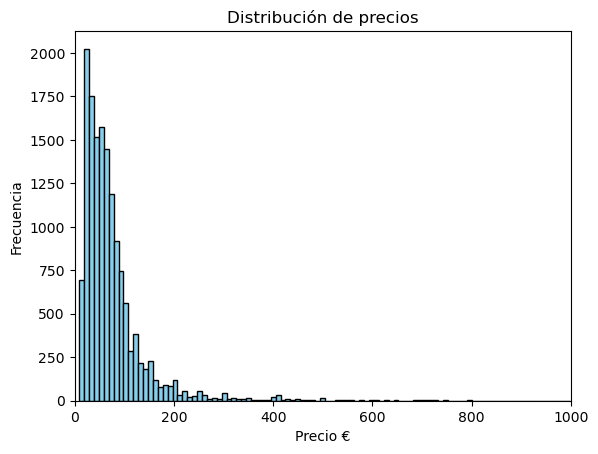

In [6]:
plt.hist(df['Price'], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribución de precios")
plt.xlabel("Precio €")
plt.ylabel("Frecuencia")
plt.xlim(0, 1000)
plt.show()

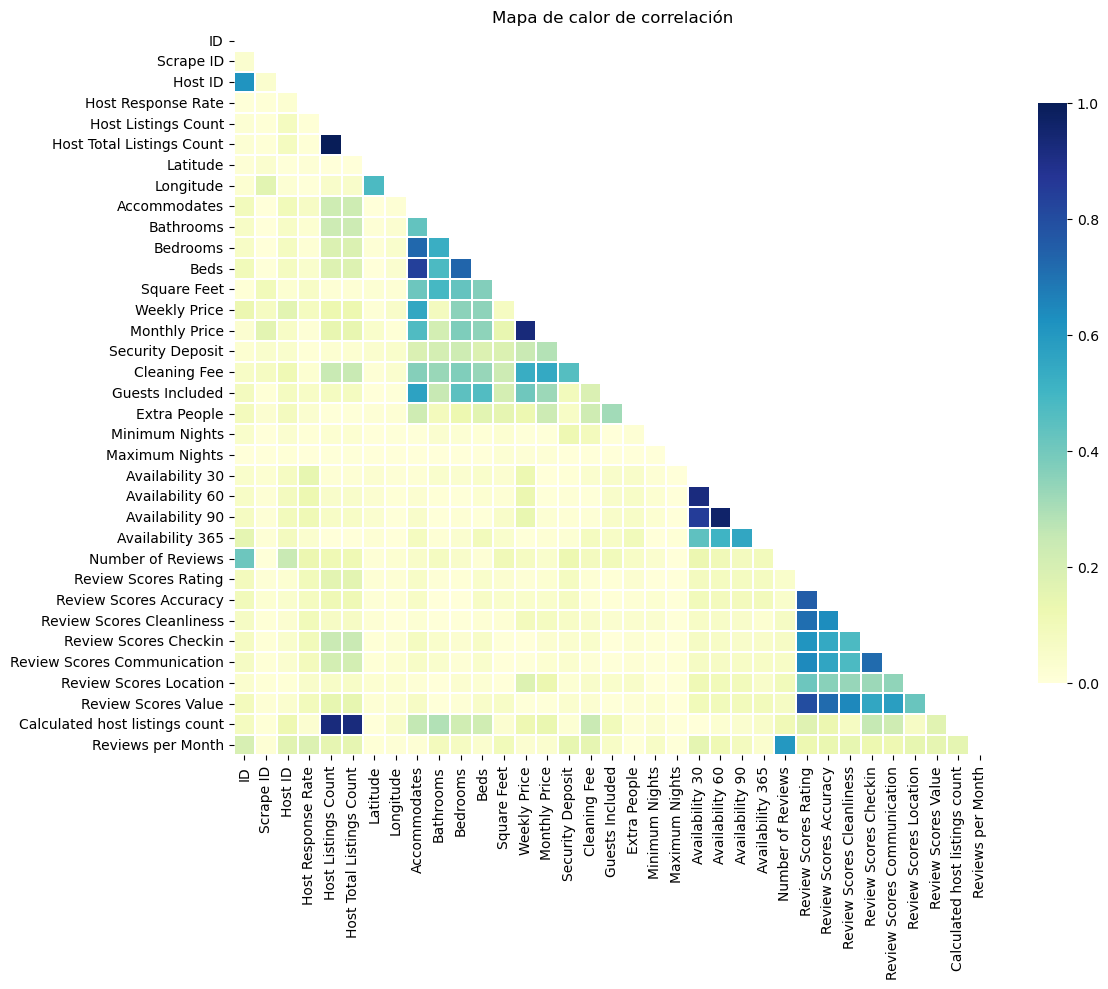

In [7]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr = np.abs(numeric_df.drop(['Price'], axis=1).corr())

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, center=0.5,
            linewidths=0.1, cmap="YlGnBu", cbar_kws={"shrink": 0.8})
plt.title("Mapa de calor de correlación")
plt.tight_layout()
plt.show()

Despues de analizar el database, concluimos que hay que eliminar columnas que sean texto, ids, enlaces, imagenes y columnas que estén muy correlacionadas con otras ya que todos estos valores no añaden información extra y útil por lo que generan ruido. Además eliminamos columnas que tengan menos del 50 % de los datos ya que consideramos que no son tan relevantes.
El resultado de este analisis es el siguiente:

In [8]:
cols_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview', 
    'Notes', 'Transit', 'Access', 'Beds', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url','XL Picture Url', 'Host ID', 'Host URL',
    'Host Listings Count', 'Host Total Listings Count', 'Host Name', 'Host Since', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url',
    'Street', 'Smart Location', 'Country Code', 'Country', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 'Last Review', 'License', 'Jurisdiction Names',
    'Has Availability', 'Geolocation', 'Features', 'Monthly Price', 'Availability 30', 'Availability 90', 'Review Scores Value', 'Review Scores Accuracy', 'Host Response Time', 
    'Host Response Rate', 'Host Neighbourhood', 'Host Verifications', 'Market', 'Neighbourhood', 'State', 'City', 'Neighbourhood Group Cleansed', 'Zipcode', 'Amenities', 'Bed Type'
]

df_cleaned = df.drop(columns=cols_to_drop, errors='ignore')

less_50 = 0.5

df_cleaned = df_cleaned.loc[:, df_cleaned.isnull().mean() < less_50]

Una vez limpiado las columnas que estorban para hacer el modelo, debemos encontrar las columnas que tengan nulos y rellenarlos de alguna manera

In [9]:
df_cleaned.isnull().sum().sort_values(ascending=False).head(10)

Cleaning Fee                   6093
Review Scores Location         3340
Review Scores Checkin          3337
Review Scores Communication    3320
Review Scores Cleanliness      3320
Review Scores Rating           3304
Reviews per Month              3162
Bathrooms                        55
Bedrooms                         25
Price                            17
dtype: int64

Cambiamos los nulos de la columna Cleaning Fee por ceros y los nulos de las columnas 'Review Scores Location', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Cleanliness', 'Review Scores Rating', 'Reviews per Month', 'Calculated host listings count' por la media. Además, eliminamos los datos que tienen null en las columnas Price, Bathrooms, Bedrooms.

In [10]:
df_cleaned['Cleaning Fee'] = df_cleaned['Cleaning Fee'].fillna(0)
df_cleaned = df_cleaned[df_cleaned['Price'].notnull()]
df_cleaned = df_cleaned[df_cleaned['Bathrooms'].notnull()]
df_cleaned = df_cleaned[df_cleaned['Bedrooms'].notnull()]

cols = ['Review Scores Location', 'Review Scores Checkin', 'Review Scores Communication',
        'Review Scores Cleanliness', 'Review Scores Rating', 'Reviews per Month', 'Calculated host listings count']
for col in cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

#print(df_cleaned.shape)
#print(df_cleaned.head())
#print(df_cleaned.info())

Transformamos las columnas de texto por numeros:

In [11]:
top_100 = df_cleaned['Neighbourhood Cleansed'].value_counts().nlargest(100).index
df_cleaned['Neighbourhood Grouped'] = df_cleaned['Neighbourhood Cleansed'].apply(
    lambda x: x if x in top_100 else 'Other'
)
df_cleaned.drop('Neighbourhood Cleansed', axis=1, inplace=True)


In [12]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['Neighbourhood Grouped','Property Type', 'Room Type', 'Cancellation Policy'], drop_first=True)

Codigo que me ayuda a encontrar un numero optimo de los top Neighbourhood Cleansed:

In [13]:
grouped_columns = [col for col in df_cleaned.columns if 'Neighbourhood Grouped' in col]

for col in grouped_columns:
    true_count = df_cleaned[col].sum()
    if true_count < 25:
        print(f"Columna {col} tiene {true_count} valores True:")
        print(df_cleaned[col].value_counts())
        print("\n")

Columna Neighbourhood Grouped_Alameda de Osuna tiene 23 valores True:
Neighbourhood Grouped_Alameda de Osuna
False    14661
True        23
Name: count, dtype: int64


Columna Neighbourhood Grouped_Atocha tiene 18 valores True:
Neighbourhood Grouped_Atocha
False    14666
True        18
Name: count, dtype: int64


Columna Neighbourhood Grouped_Buenavista tiene 24 valores True:
Neighbourhood Grouped_Buenavista
False    14660
True        24
Name: count, dtype: int64


Columna Neighbourhood Grouped_Calvià tiene 18 valores True:
Neighbourhood Grouped_Calvià
False    14666
True        18
Name: count, dtype: int64


Columna Neighbourhood Grouped_Campamento tiene 22 valores True:
Neighbourhood Grouped_Campamento
False    14662
True        22
Name: count, dtype: int64


Columna Neighbourhood Grouped_Casco Histórico de Vicálvaro tiene 21 valores True:
Neighbourhood Grouped_Casco Histórico de Vicálvaro
False    14663
True        21
Name: count, dtype: int64


Columna Neighbourhood Grouped_Fontarró

Una vez limpiado y codificado los datos volvemos a explorar y ver posibles correlaciones

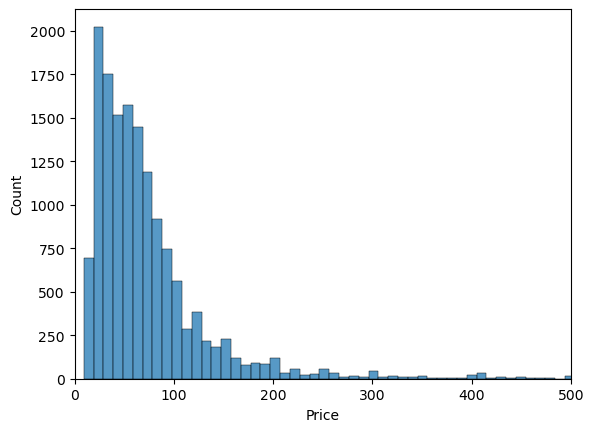

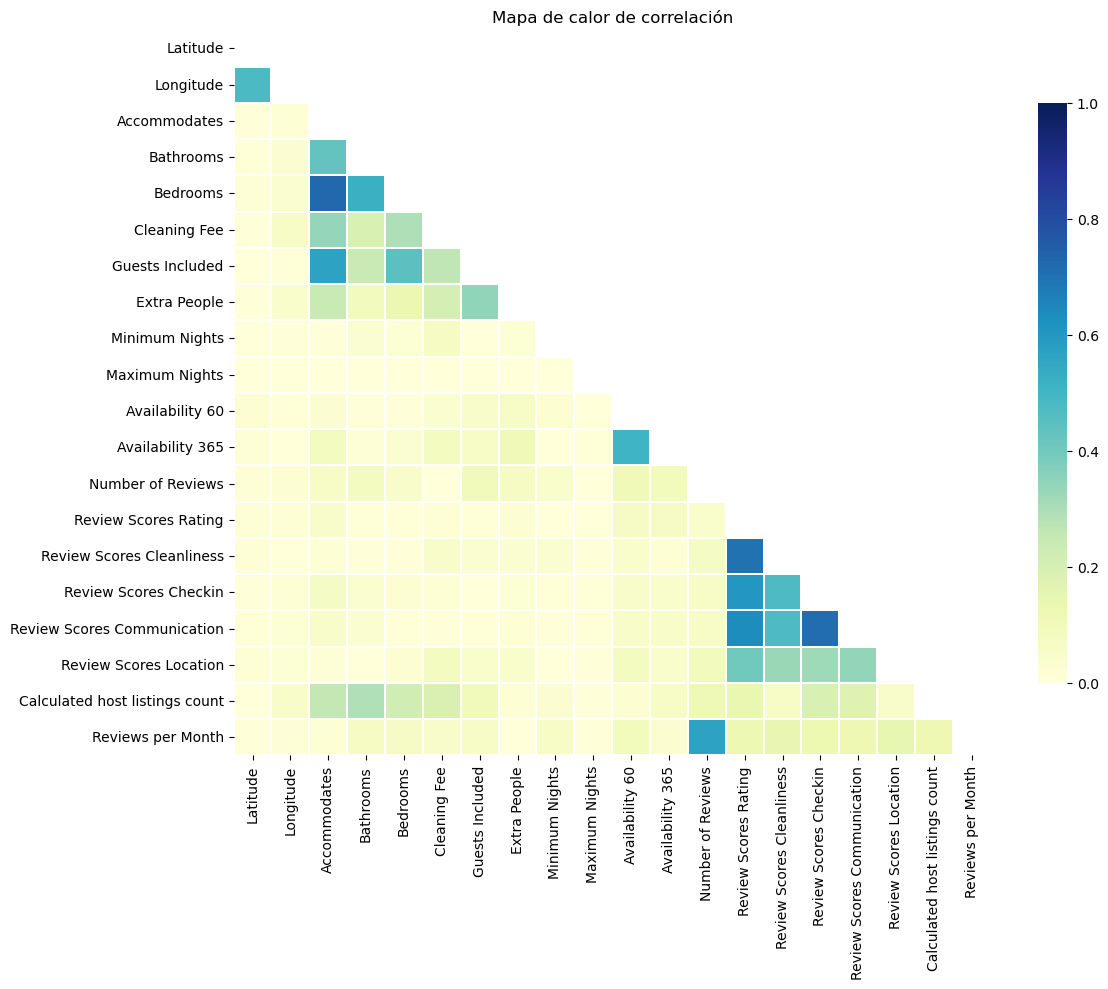

In [14]:
sns.histplot(df['Price'], bins=100)
plt.xlim(0, 500)
plt.show()

numeric_df = df_cleaned.select_dtypes(include=['int64', 'float64'])

corr = np.abs(numeric_df.drop(['Price'], axis=1).corr())

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, center=0.5,
            linewidths=0.1, cmap="YlGnBu", cbar_kws={"shrink": 0.8})
plt.title("Mapa de calor de correlación")
plt.tight_layout()
plt.show()



Toca hacer separar en train (80%) y test (20%):

In [15]:
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)


Utilizo RandomForest como modelo:
(**)

In [17]:
rf_model = RandomForestRegressor(n_estimators= 200,random_state=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=10)

In [19]:
print(df_cleaned.shape)

(14684, 151)


In [ ]:

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


In [ ]:
cv_scores = cross_val_score(rf_model, X, y, cv=3, scoring='neg_mean_squared_error')

print(f'Cross-validation RMSE: {np.sqrt(-cv_scores.mean())}')


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200,300],
    'max_depth': [5,10, 20, None]
}

rf_model = RandomForestRegressor(random_state=10)

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

best_rf_model = grid_search.best_estimator_

y_pred_best = best_rf_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f'Mean Absolute Error (MAE) with best model: {mae_best}')
print(f'Root Mean Squared Error (RMSE) with best model: {rmse_best}')


El resultado es:

Mean Absolute Error (MAE) with best model: 20.916239359891044
Root Mean Squared Error (RMSE) with best model: 48.43256422385937

Estos datos son un poco "pobres" por lo que lo voy a volver eliminando algunos outliers para afinar el modelo.

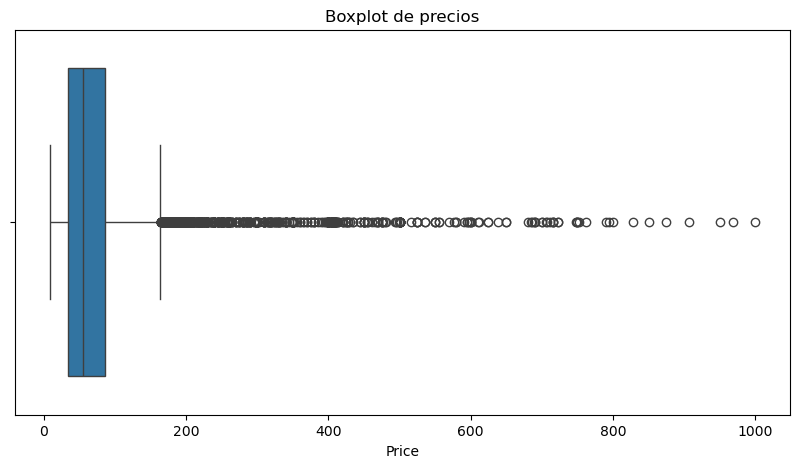

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cleaned['Price'])
plt.title('Boxplot de precios')
plt.show()


In [21]:
Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(IQR)

52.0


In [22]:
df_cleaned = df_cleaned[(df_cleaned['Price'] >= lower_bound) & (df_cleaned['Price'] <= upper_bound)]

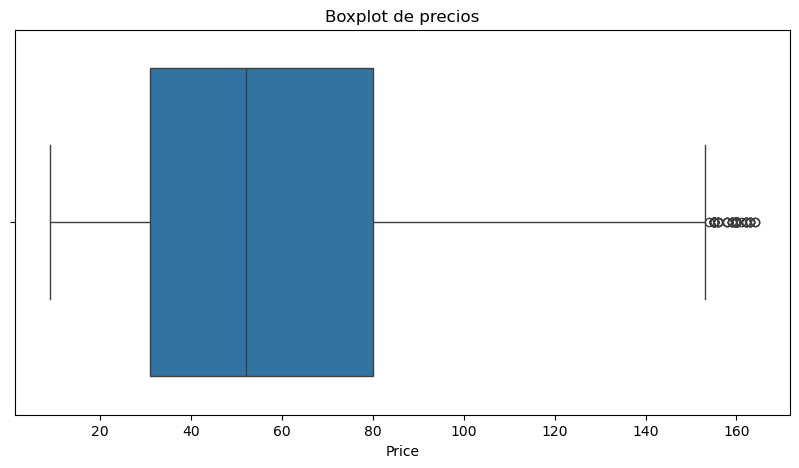

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cleaned['Price'])
plt.title('Boxplot de precios')
plt.show()


EJECUTO EL MODELO DE NUEVO (**)